In [1]:

import random
import re
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency
import statsmodels.api as sm
import numpy as np
pd.options.display.max_colwidth = 1000
pd.options.mode.chained_assignment = None


##### Load Data

In [2]:
df = pd.read_excel('../data_processed/men_activists.xlsx')

##### Drop Null, Empty, and NaN values

In [3]:
df.dropna(subset=['text'], inplace=True) #remove nan value
df.drop_duplicates(subset=['text'], inplace=True) #remove nan duplicate value
df = df.dropna(axis=1, how='all')
df = df.dropna(axis=1, how='all').loc[:, df.notna().any()]

##### Clean Data

In [4]:
def clean_tweet_text(text):
    # Check for null or NaN values
    if pd.isnull(text):
        return text
    # Remove URL
    text = re.sub(r'http\S+', '', text)
    
    # Remove RT (retweet) tag
    text = text.replace('RT', '')
    
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Remove special characters and punctuations, and add a space after removing them
    text = re.sub(r'[^\w\s]', '', text)

    # Remove hashtags
    text = re.sub(r'#(\w+)', '', str(text))
    # Remove extra spaces
    text = ' '.join(text.split())
    
    # Convert to lowercase
    text = text.lower()
    
    return text
# Apply the cleaning function to 'text' column
df['text'] = df['text'].apply(clean_tweet_text)


##### Remove Text Less then 30 characters

In [5]:
# df = pd.read_excel('../data_processed/men_activists.xlsx')

In [6]:
df = df[df['text'].str.len() >=30]

##### Remove Empty Rows

In [7]:
def remove_empty_rows(df):
    # Iterate over each column in the DataFrame
    for column in df.columns:
        # Remove rows with empty values in the column
        df = df[df[column].notna() & df[column].astype(str).str.strip().ne('')]
    return df

df = remove_empty_rows(df)


##### Remove All Null Values

In [8]:
def remove_null_columns(df):
    # Iterate over each column in the DataFrame
    for column in df.columns:
        # Check if the column contains any null values
        if df[column].isnull().any():
            # If any null value exists, drop the column
            df = df.drop(column, axis=1)
    return df
df = remove_null_columns(df)


##### Remove Stopwords

In [9]:
from nltk.corpus import stopwords
def remove_stopwords(df):
    stop_words = set(stopwords.words('english'))
    df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
    return df
df = remove_stopwords(df)

##### Convert Timezone

In [10]:
df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce').dt.date.astype(str)

##### Drop the whole rows which is >=2020

In [11]:
df["created_at"] = pd.to_datetime(df["created_at"], format="%Y-%m-%d")
filtered_df = df[df["created_at"].dt.year >= 2020]
df.drop(df[df["created_at"].dt.year <= 2020].index, inplace=True)


##### Check How Many accounts are there

In [12]:
len(df['name'].unique())

54

##### Labeling Process

In [13]:
df['text'] = df['text'].str.lower()
df['text'] = df['text'].astype(str)

In [14]:
def label_tweets(text):
    keywords = ['education', 'school', 'university', 'women', 'girl']
    for keyword in keywords:
        if keyword in text.lower():
            return 1
    return 0
df = df.copy()
df['label'] = df['text'].apply(label_tweets)

##### Sentiment Analysis

In [15]:
x = df['text']
sentiment_labels = []
sentiment_scores = []
for tweet in x:
    # Create a TextBlob object
    blob = TextBlob(tweet)
    # Get the sentiment polarity (-1 to 1)
    polarity = blob.sentiment.polarity
    if polarity > 0:
        sentiment = 'positive'
    elif polarity < 0:
        sentiment = 'negative'
    else:
        sentiment = 'neutral'
    
    sentiment_labels.append(sentiment)
    sentiment_scores.append(polarity)
# Add the sentiment labels and scores as new columns in the DataFrame
df['sentiment'] = sentiment_labels
df['sentiment_score'] = sentiment_scores

##### Data Set Summary

In [16]:
sentiment_counts = df['sentiment'].value_counts()
print("Sentiment Counts:\n", sentiment_counts)
total_counts = sentiment_counts['positive'] + sentiment_counts['negative']
print("Total Counts:", total_counts)

Sentiment Counts:
 sentiment
neutral     8131
positive    5104
negative    3844
Name: count, dtype: int64
Total Counts: 8948


##### Calculate positive tweets and percentage for women, single user

In [17]:
women_positive_count = df[(df['gender'] == 'male') & (df['sentiment'] == 'positive')].shape[0]
women_total_count = df[df['gender'] == 'male'].shape[0]
women_positive_percentage = (women_positive_count / women_total_count) * 100
# Print the results
print("Positive tweets from men:", women_positive_count, "(", women_positive_percentage, "%)")

Positive tweets from men: 5104 ( 29.88465366824756 %)


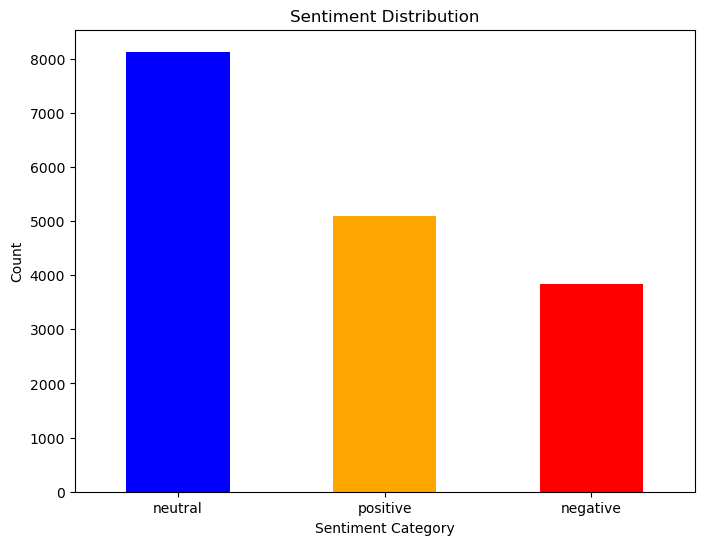

Sentiment Distribution: 8948


In [18]:
# Define custom colors for sentiment categories
colors = {'negative': 'red', 'neutral': 'blue', 'positive': 'orange'}

# Calculate sentiment counts
sentiment_counts = df['sentiment'].value_counts()

# Plot the sentiment counts with custom colors
plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color=[colors.get(x, 'gray') for x in sentiment_counts.index])
plt.xlabel('Sentiment Category')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.title('Sentiment Distribution')
plt.show()

# Calculate total counts
total_counts = sentiment_counts['positive'] + sentiment_counts['negative']
print("Sentiment Distribution:", total_counts)


##### Content Analysis

In [19]:
df_edu = df.loc[df['label'] == 1]
print("Number of tweets in favor of education: ", len(df_edu))

Number of tweets in favor of education:  6349


In [20]:
df.shape

(17079, 8)

##### Code Schema

In [21]:
coding_scheme = {
'women': ['women', 'woman', 'female', 'feminine', 'girl', 'lady'],
'education': ['education', 'educational', 'learning', 'academics', 'knowledge'],
'school': ['school', 'classroom', 'teacher', 'students', 'curriculum'],
'university': ['university', 'college', 'higher education', 'academia', 'campus'],
'access': ['access', 'opportunity', 'enrollment', 'attendance', 'entry'],
'quality': ['quality', 'standard', 'curriculum', 'teaching', 'learning'],
'benefits': ['benefit', 'advantage', 'improvement', 'progress'],
'barriers': ['barrier', 'restriction', 'obstacle', 'challenge', 'difficulty'],
'empowerment': ['empower', 'empowering', 'confidence', 'self-esteem', 'agency'],
'gender': ['gender', 'discriminatioan', 'inequality', 'feminism', 'patriarchy']
}

# Define a function to apply the coding scheme to each tweet
def apply_coding_scheme(text):
    codes = []
    for code, keywords in coding_scheme.items():
        for keyword in keywords:
            if keyword in text.lower():
                codes.append(code)
    return codes

# Apply the coding scheme to the text column and create a new column for the codes
df_edu['codes'] = df_edu['text'].apply(apply_coding_scheme)

In [22]:
df_edu[['text','sentiment','sentiment_score','gender','label','codes']].sample(5)

,text,sentiment,sentiment_score,gender,label,codes
13998,ministry foreign affairs saudi arabia expresses surprise regret response talibans decision close university girl taliban,negative,-0.125000,male,1,"[women, university]"
9334,pakistani prime minister shehbaz sharif asked taliban provide education girl work afghan women respect rights afghan women,neutral,0.000000,male,1,"[women, women, education]"
1134,remember pashtun girl nobel peace prize work education nearly got killed,negative,-0.050000,male,1,"[women, education]"
11938,short video long documentary sayedeshuhada school heartbreaking stop hazara genocide,negative,-0.016667,male,1,[school]
11197,richard betts professor columbia university writes rarely everyone must read lis,positive,0.300000,male,1,[university]


##### Visualization

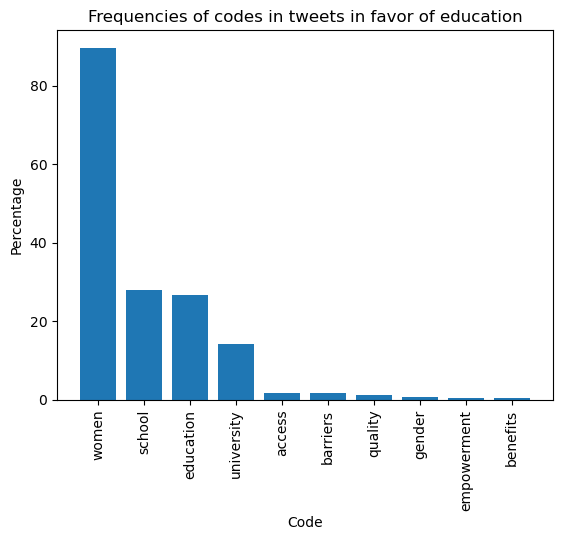

In [23]:
df_codes = df_edu.explode('codes')
# Calculate the frequency and percentage of each code
code_freq = df_codes['codes'].value_counts()
code_perc = code_freq / len(df_edu) * 100
# Plot the code frequencies as a bar chart
plt.bar(code_perc.index, code_perc.values)
plt.title('Frequencies of codes in tweets in favor of education')
plt.xlabel('Code')
plt.xticks(rotation=90)
plt.ylabel('Percentage')
plt.show()

In [24]:
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
# Initialize the sentiment analyzer
sid = SentimentIntensityAnalyzer()
# Loop through each keyword and calculate the sentiment of tweets containing that keyword
for keyword in ['women', 'education', 'school', 'university', 'girl']:
    keyword_tweets = df_edu[df_edu['text'].str.contains(keyword)].copy()
    keyword_tweets.loc[:, 'sentiment_score'] = keyword_tweets['text'].apply(lambda x: sid.polarity_scores(x)['compound'])
    print(f"Sentiment analysis of tweets containing the keyword '{keyword}':")
    print(keyword_tweets.groupby('sentiment')['text'].count())


Sentiment analysis of tweets containing the keyword 'women':
sentiment
negative     519
neutral     1629
positive     882
Name: text, dtype: int64
Sentiment analysis of tweets containing the keyword 'education':
sentiment
negative    229
neutral     631
positive    656
Name: text, dtype: int64
Sentiment analysis of tweets containing the keyword 'school':
sentiment
negative    346
neutral     648
positive    371
Name: text, dtype: int64
Sentiment analysis of tweets containing the keyword 'university':
sentiment
negative    121
neutral     432
positive    207
Name: text, dtype: int64
Sentiment analysis of tweets containing the keyword 'girl':
sentiment
negative     504
neutral     1091
positive     719
Name: text, dtype: int64


##### Sentiment percentage for each keywords

In [25]:
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
import pandas as pd
# Initialize the sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Create a DataFrame to store the sentiment percentages for each keyword
keyword_sentiments = pd.DataFrame(columns=['Positive', 'Negative', 'Neutral'])

# Loop through each keyword and calculate the sentiment of tweets containing that keyword
for keyword in ['women', 'education', 'school', 'university', 'girl']:
    keyword_tweets = df_edu[df_edu['text'].str.contains(keyword)].copy()
    keyword_tweets['sentiment_score'] = keyword_tweets['text'].apply(lambda x: sid.polarity_scores(x)['compound'])
    # Calculate the sentiment distribution for the keyword
    sentiment_distribution = keyword_tweets.groupby('sentiment')['text'].count()
    total_tweets = sentiment_distribution.sum()
    # Calculate the percentage of each sentiment category
    sentiment_percentage = sentiment_distribution / total_tweets * 100
    # Add the sentiment percentages to the DataFrame
    keyword_sentiments.loc[keyword] = sentiment_percentage.values

# Calculate the average sentiment percentages across all keywords
average_sentiments = keyword_sentiments.mean()

# Print the average sentiment percentages
print("Average sentiment percentages:")
for sentiment, percentage in average_sentiments.items():
    print(f"{sentiment}: {percentage:.2f}%")


Average sentiment percentages:
Positive: 19.06%
Negative: 49.37%
Neutral: 31.57%


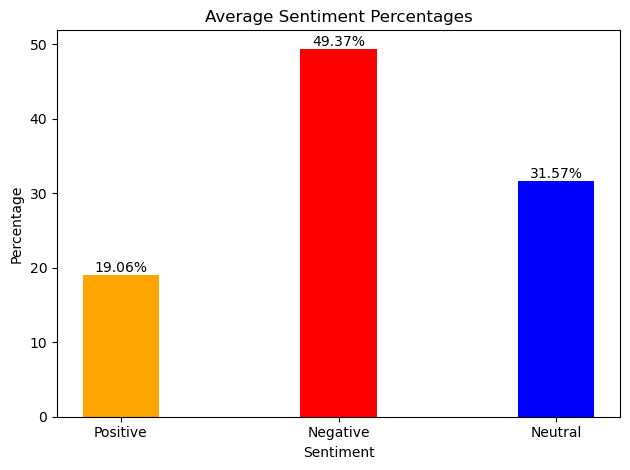

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Define colors for each sentiment category
colors = {'Positive': 'orange', 'Negative': 'red', 'Neutral': 'blue'}

# Calculate the average sentiment percentages across all keywords
average_sentiments = keyword_sentiments.mean()

# Plot the average sentiment percentages
fig, ax = plt.subplots()

# Create a bar plot
bar_width = 0.35
index = np.arange(len(average_sentiments))
bars = ax.bar(index, average_sentiments, bar_width, color=[colors[sentiment] for sentiment in average_sentiments.index])

# Add labels and percentages on top of each bar
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}%', ha='center', va='bottom')

# Customize the plot
ax.set_xlabel('Sentiment')
ax.set_ylabel('Percentage')
ax.set_title('Average Sentiment Percentages')
ax.set_xticks(index)
ax.set_xticklabels(average_sentiments.index)

# Display the plot
plt.tight_layout()
plt.show()


In [27]:
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

# Initialize the sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Loop through each keyword and calculate the sentiment of tweets containing that keyword
for keyword in ['women', 'education', 'school', 'university', 'girl']:
    keyword_tweets = df_edu[df_edu['text'].str.contains(keyword)].copy()
    keyword_tweets['sentiment_score'] = keyword_tweets['text'].apply(lambda x: sid.polarity_scores(x)['compound'])
    
    # Calculate the sentiment distribution for the keyword
    sentiment_distribution = keyword_tweets.groupby('sentiment')['text'].count()
    total_tweets = sentiment_distribution.sum()
    
    # Calculate the percentage of each sentiment category
    sentiment_percentage = sentiment_distribution / total_tweets * 100
    
    print(f"Sentiment analysis of tweets containing the keyword '{keyword}':")
    for sentiment, count in sentiment_distribution.items():
        percentage = sentiment_percentage[sentiment]
        if sentiment == 'positive':
            sentiment_label = 'Positive'
        elif sentiment == 'negative':
            sentiment_label = 'Negative'
        else:
            sentiment_label = 'Neutral'
        print(f"{sentiment_label}: {count} ({percentage:.2f}%)")


Sentiment analysis of tweets containing the keyword 'women':
Negative: 519 (17.13%)
Neutral: 1629 (53.76%)
Positive: 882 (29.11%)
Sentiment analysis of tweets containing the keyword 'education':
Negative: 229 (15.11%)
Neutral: 631 (41.62%)
Positive: 656 (43.27%)
Sentiment analysis of tweets containing the keyword 'school':
Negative: 346 (25.35%)
Neutral: 648 (47.47%)
Positive: 371 (27.18%)
Sentiment analysis of tweets containing the keyword 'university':
Negative: 121 (15.92%)
Neutral: 432 (56.84%)
Positive: 207 (27.24%)
Sentiment analysis of tweets containing the keyword 'girl':
Negative: 504 (21.78%)
Neutral: 1091 (47.15%)
Positive: 719 (31.07%)


In [28]:
for keyword in ['women education']:
    keyword_tweets = df_edu[df_edu['text'].str.contains(keyword)].copy()
    keyword_tweets.loc[:, 'sentiment_score'] = keyword_tweets['text'].apply(lambda x: sid.polarity_scores(x)['compound'])
    print(f"Sentiment analysis of tweets containing the keyword '{keyword}':")
    print(keyword_tweets.groupby('sentiment')['text'].count())

Sentiment analysis of tweets containing the keyword 'women education':
sentiment
negative     8
neutral     52
positive    28
Name: text, dtype: int64


In [29]:
for keyword in ['women education']:
    keyword_tweets = df_edu[df_edu['text'].str.contains(keyword)].copy()
    keyword_tweets.loc[:, 'sentiment_score'] = keyword_tweets['text'].apply(lambda x: sid.polarity_scores(x)['compound'])
    sentiment_counts = keyword_tweets.groupby('sentiment')['text'].count()
    total_count = sentiment_counts.sum()
    sentiment_percentages = (sentiment_counts / total_count) * 100
    result = sentiment_counts.astype(str) + ' (' + sentiment_percentages.round(1).astype(str) + '%)'
    print(f"Sentiment analysis of tweets containing the keyword '{keyword}':")
    print(result)


Sentiment analysis of tweets containing the keyword 'women education':
sentiment
negative      8 (9.1%)
neutral     52 (59.1%)
positive    28 (31.8%)
Name: text, dtype: object


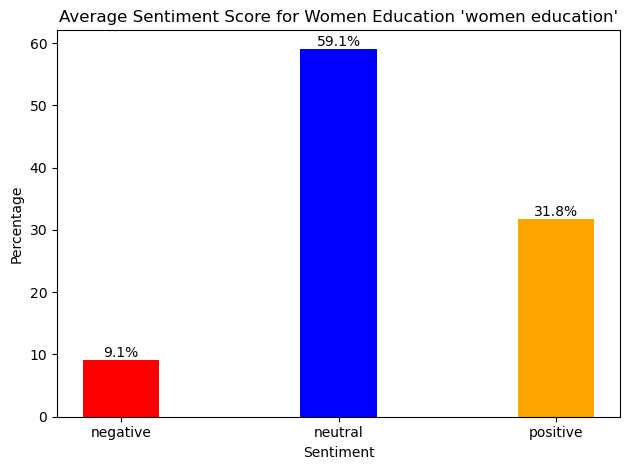

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Define colors for each sentiment category
colors = {'positive': 'orange', 'negative': 'red', 'neutral': 'blue'}

# Define the keyword
keyword = 'women education'

# Filter tweets containing the keyword
keyword_tweets = df_edu[df_edu['text'].str.contains(keyword)].copy()

# Calculate the sentiment counts and percentages
sentiment_counts = keyword_tweets.groupby('sentiment')['text'].count()
total_count = sentiment_counts.sum()
sentiment_percentages = (sentiment_counts / total_count) * 100

# Plot the sentiment percentages
fig, ax = plt.subplots()

# Create a bar plot
index = np.arange(len(sentiment_percentages))
bars = ax.bar(index, sentiment_percentages, bar_width, color=[colors[sentiment] for sentiment in sentiment_percentages.index])

# Add labels and percentages on top of each bar
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.1f}%', ha='center', va='bottom')

# Customize the plot
ax.set_xlabel('Sentiment')
ax.set_ylabel('Percentage')
ax.set_title(f"Average Sentiment Score for Women Education '{keyword}'")
ax.set_xticks(index)
ax.set_xticklabels(sentiment_percentages.index)

# Display the plot
plt.tight_layout()
plt.show()


##### Average sentiment

In [31]:
import random
from textblob import TextBlob
keywords = ['women education']
all_tweets = [row['text'] for _, row in df.iterrows() if any(keyword in row['text'] for keyword in keywords)]
sample_tweets = random.sample(all_tweets, k=min(10, len(all_tweets)))
mean_sentiment = sum(TextBlob(tweet).sentiment.polarity for tweet in all_tweets) / len(all_tweets) if all_tweets else 0
print(f"Average sentiment score for women education: {mean_sentiment}")


Average sentiment score for women education: 0.050844278827233386


##### Sentiment Category

In [32]:
import numpy as np
category_sentiment = df_edu.groupby(df_edu['codes'].apply(tuple))['text'].apply(lambda x: np.mean([TextBlob(tweet).sentiment.polarity for tweet in x]))
print("Sentiment Scores by Category:")
category_sentiment.head()

Sentiment Scores by Category:


codes
(education,)              0.061623
(education, access)       0.041667
(education, barriers)     0.000000
(education, benefits)     0.095739
(education, education)    0.098434
Name: text, dtype: float64

##### Calculate the sentiment scores for all tweets

In [33]:
sentiment_scores = [TextBlob(tweet).sentiment.polarity for tweet in df['text']]
# Compare the sentiment distributions using a t-test
t_stat, p_value = stats.ttest_1samp(sentiment_scores, 0)
print("Comparison of Sentiment For whole tweets:")
print("T-statistic:", t_stat)
print("P-value:", p_value)


Comparison of Sentiment For whole tweets:
T-statistic: 13.798227652339987
P-value: 4.44754732493708e-43


In [34]:
import scipy.stats as stats
from textblob import TextBlob

keywords = ['women', 'education', 'school', 'university', 'girl']

# Filter tweets containing the keywords
men_education_tweets = df[df['text'].str.contains('|'.join(keywords), case=False)]

# Calculate sentiment scores using TextBlob
sentiment_scores = [TextBlob(tweet).sentiment.polarity for tweet in men_education_tweets['text']]

# Perform one-sample t-test
t_stat, p_value = stats.ttest_1samp(sentiment_scores, 0)

# Print the comparison results
print("Comparison of Sentiment for Women Education Tweets:")
print("T-statistic:", t_stat)
print("P-value:", p_value)


Comparison of Sentiment for Women Education Tweets:
T-statistic: 12.44785498860857
P-value: 3.6865531178524607e-35


In [35]:
import scipy.stats as stats
from textblob import TextBlob

keywords = ['women education']

# Filter tweets containing the keywords
men_education_tweets = df[df['text'].str.contains('|'.join(keywords), case=False)]

# Calculate sentiment scores using TextBlob
sentiment_scores = [TextBlob(tweet).sentiment.polarity for tweet in men_education_tweets['text']]

# Perform one-sample t-test
t_stat, p_value = stats.ttest_1samp(sentiment_scores, 0)

# Print the comparison results
print("Comparison of Sentiment for Women Education Tweets:")
print("T-statistic:", t_stat)
print("P-value:", p_value)


Comparison of Sentiment for Women Education Tweets:
T-statistic: 2.5953068802040136
P-value: 0.011091143507551329


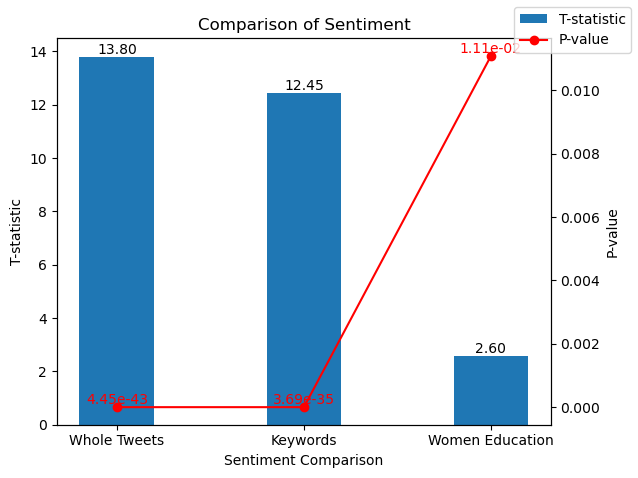

In [36]:
import matplotlib.pyplot as plt

# Define the sentiment comparisons
sentiment_comparisons = {
    'Whole Tweets': {
        'T-statistic': 13.798227652339987,
        'P-value': 4.44754732493708e-43
    },
    'Keywords': {
        'T-statistic': 12.44785498860857,
        'P-value': 3.6865531178524607e-35
    },
    'Women Education': {
        'T-statistic': 2.5953068802040136,
        'P-value': 0.011091143507551329
    }
}

# Plot the sentiment comparisons
fig, ax = plt.subplots()
index = range(len(sentiment_comparisons))
t_statistics = [comparison['T-statistic'] for comparison in sentiment_comparisons.values()]
p_values = [comparison['P-value'] for comparison in sentiment_comparisons.values()]

# Create a bar plot for T-statistics
bar_width = 0.4
ax.bar(index, t_statistics, bar_width, label='T-statistic')
ax.set_xlabel('Sentiment Comparison')
ax.set_ylabel('T-statistic')
ax.set_title('Comparison of Sentiment')
ax.set_xticks(index)
ax.set_xticklabels(sentiment_comparisons.keys())

# Add labels for T-statistics
for i, t_stat in enumerate(t_statistics):
    ax.text(i, t_stat, f'{t_stat:.2f}', ha='center', va='bottom')

# Create a line plot for P-values
ax2 = ax.twinx()
ax2.plot(index, p_values, color='red', marker='o', linestyle='-', label='P-value')
ax2.set_ylabel('P-value')

# Add labels for P-values
for i, p_value in enumerate(p_values):
    ax2.text(i, p_value, f'{p_value:.2e}', ha='center', va='bottom', color='red')

# Display the legend
fig.legend(loc='upper right')

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()


#### Calculate the sentiment scores for tweets containing each keyword

In [37]:
keyword_sentiment = {}
for keyword in keywords:
    keyword_tweets = df_edu[df_edu['text'].str.contains(keyword)]
    sentiment_scores = [TextBlob(tweet).sentiment.polarity for tweet in keyword_tweets['text']]
    keyword_sentiment[keyword] = np.mean(sentiment_scores)
print("Sentiment Scores by Keyword:")
for keyword, sentiment_score in keyword_sentiment.items():
    print(f"{keyword}: {sentiment_score}")


Sentiment Scores by Keyword:
women education: 0.05084427882723337


##### Chi-square test of independence

In [38]:
from scipy.stats import chi2_contingency
contingency_table = pd.crosstab(df['sentiment'], df['label'] == 1)
chi2, p_value, _, _ = chi2_contingency(contingency_table)
# Print the results
print("Chi-square Test of Independence:")
print("Chi-square:", chi2)
print("P-value:", p_value)


Chi-square Test of Independence:
Chi-square: 53.57292547279976
P-value: 2.326949958888272e-12


##### Create a cross-tabulation between sentiment and gender

In [39]:
cross_tab = pd.crosstab(df['sentiment'], df['gender'])
# Print the cross-tabulation
print("Cross-Tabulation of Sentiment and Gender:")
print(cross_tab)

Cross-Tabulation of Sentiment and Gender:
gender     male
sentiment      
negative   3844
neutral    8131
positive   5104


In [40]:
cross_tab = pd.crosstab(df['gender'], df['label'])
# Print the cross-tabulation
print("Cross-Tabulation of Gender and Label:")
print(cross_tab)

Cross-Tabulation of Gender and Label:
label       0     1
gender             
male    10730  6349


##### Calculate descriptive statistics for women


In [41]:
men_sentiment_scores = [TextBlob(tweet).sentiment.polarity for tweet in df[df['gender'] == 'male']['text']]
# Calculate descriptive statistics for men
men_mean_sentiment = np.mean(men_sentiment_scores)
men_median_sentiment = np.median(men_sentiment_scores)
men_std_sentiment = np.std(men_sentiment_scores)
men_quartiles_sentiment = np.percentile(men_sentiment_scores, [25, 50, 75])

print("Descriptive Statistics for Men:")
print("Mean Sentiment:", men_mean_sentiment)
print("Median Sentiment:", men_median_sentiment)
print("Standard Deviation of Sentiment:", men_std_sentiment)
print("Quartiles of Sentiment:", men_quartiles_sentiment)

Descriptive Statistics for Men:
Mean Sentiment: 0.024885227835609675
Median Sentiment: 0.0
Standard Deviation of Sentiment: 0.23568764662084782
Quartiles of Sentiment: [0.      0.      0.08625]


##### Frequent Words

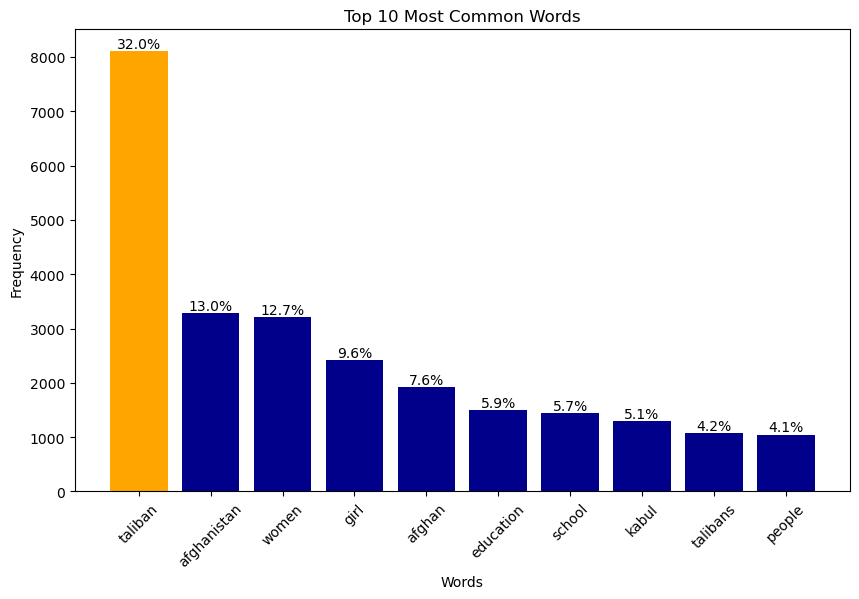

In [43]:
import matplotlib.pyplot as plt
from collections import Counter

# Combine all the text into a single string
all_text = ' '.join(df['text'].tolist())

# Split the text into individual words
all_words = all_text.split()

# Count the occurrences of each word
word_counts = Counter(all_words)

# Retrieve the most common words
most_common_words = word_counts.most_common(10)

# Extract the words and their frequencies
words = [word for word, count in most_common_words]
frequencies = [count for word, count in most_common_words]

# Calculate the total frequency of all words
total_frequency = sum(frequencies)

# Calculate the percentages
percentages = [count / total_frequency * 100 for count in frequencies]

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Create a bar chart for the most common words
bars = ax.bar(words, frequencies, color=['orange', 'darkblue', 'darkblue', 'darkblue', 'darkblue', 'darkblue', 'darkblue', 'darkblue', 'darkblue', 'darkblue'])

# Add labels and title
ax.set_xlabel('Words')
ax.set_ylabel('Frequency')
ax.set_title('Top 10 Most Common Words')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add percentage labels above each bar
for bar, percentage in zip(bars, percentages):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{percentage:.1f}%', ha='center', va='bottom')

# Show the chart
plt.show()


In [56]:
# Print the most common words and their frequencies
for word, count in most_common_words:
    print(f'{word}: {count}')

taliban: 8099
afghanistan: 3287
women: 3218
girl: 2422
afghan: 1915
education: 1495
school: 1444
kabul: 1291
talibans: 1072
people: 1047


##### Time Series

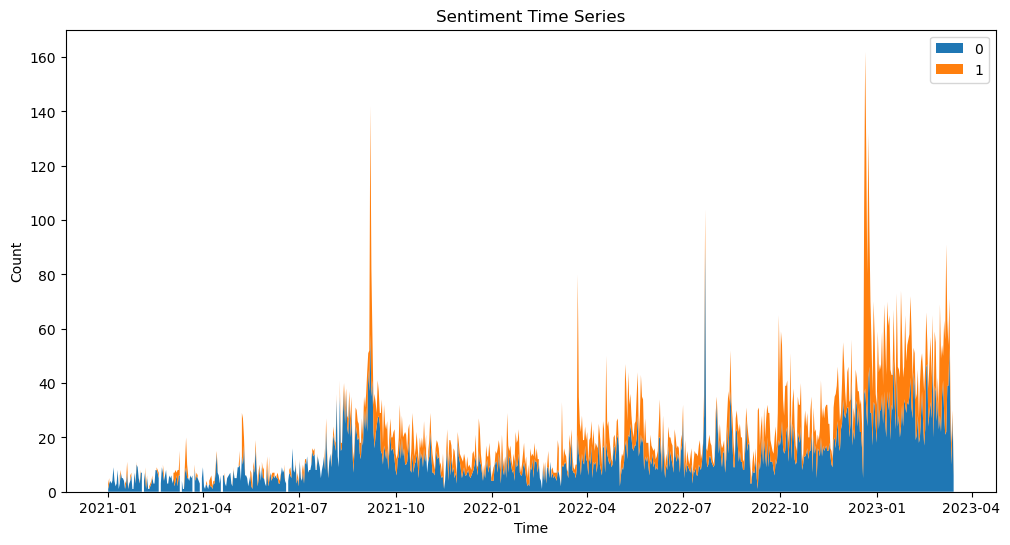

In [44]:

sentiment_counts = df.groupby(['created_at', 'label']).size().unstack()
# Extract the time periods and convert them to datetime objects
time_periods = pd.to_datetime(sentiment_counts.index)
# Set up the figure and axes
fig, ax = plt.subplots(figsize=(12, 6))
# Plot the stacked area plot for sentiment categories
ax.stackplot(time_periods, sentiment_counts.T, labels=sentiment_counts.columns)
# Add labels and title
ax.set_xlabel('Time')
ax.set_ylabel('Count')
ax.set_title('Sentiment Time Series')
# Add legend
ax.legend()
# Show the chart
plt.show()

##### Frequent Tweet

In [45]:
# Group the data by user name and count the number of tweets
user_tweet_counts = df.groupby('name').size().reset_index(name='tweet_count')

# Sort the user_tweet_counts DataFrame by tweet_count in descending order
user_tweet_counts = user_tweet_counts.sort_values(by='tweet_count', ascending=False)

# Print the top 10 users with the highest tweet counts
print(user_tweet_counts.head(10))


              name  tweet_count
5        HizbkKhan         1278
38  natiqmalikzada         1220
2    Azadi_English         1058
27        ZDaryabi          861
14     LNajafizada          757
20    OmarHaidari1          751
15     MajeedQarar          705
37   matiullahwesa          686
32     bashirgwakh          646
39       naweednow          645


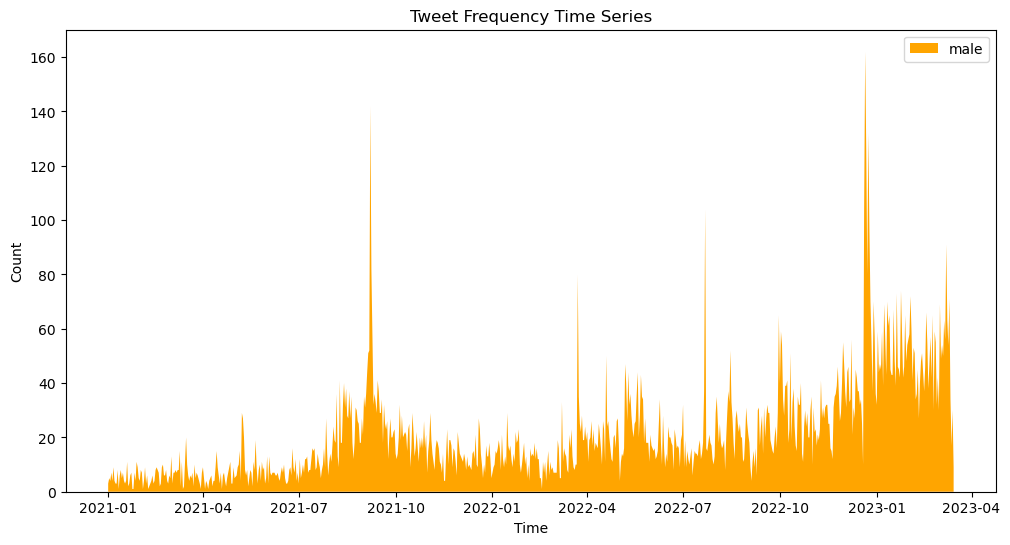

In [46]:
# Group the data by 'created_at' and 'gender', and count the number of tweets for each gender
freq_counts = df.groupby(['created_at', 'gender']).size().unstack()

# Extract the time periods and convert them to datetime objects
time_periods = pd.to_datetime(freq_counts.index)

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the stacked area plot for genders
ax.stackplot(time_periods, freq_counts.T, labels=freq_counts.columns, colors=['orange', 'darkblue'])

# Add labels and title
ax.set_xlabel('Time')
ax.set_ylabel('Count')
ax.set_title('Tweet Frequency Time Series')

# Add legend
ax.legend()

# Show the chart
plt.show()


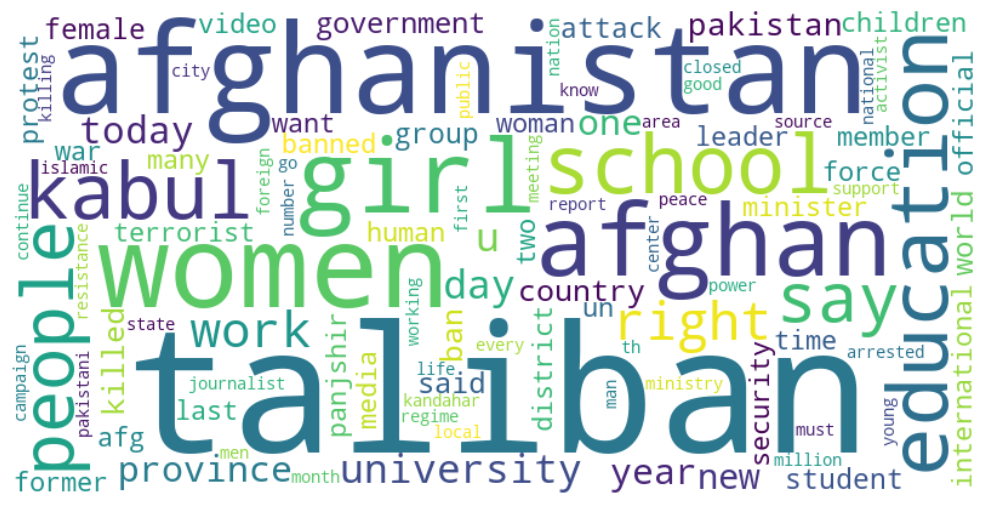

In [55]:
from wordcloud import WordCloud
text = ' '.join(df['text'])
# Create a WordCloud object with customized options
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis',
                      max_words=100, contour_width=3, contour_color='steelblue',
                      prefer_horizontal=0.8, relative_scaling=0.5,
                      collocations=False).generate(text)
# Add a central word
wordcloud.generate_from_text("Afghanistan")
# Manipulate font sizes for the central word and other words
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis',
                      max_words=100, contour_width=3, contour_color='steelblue',
                      prefer_horizontal=0.8, relative_scaling=0.5,
                      collocations=False).generate(text)
wordcloud.words_["Afghanistan"] = 80  # Set font size for the central word
# Display the word cloud using matplotlib
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout()
plt.show()


In [48]:
df.shape

(17079, 8)

In [49]:
df[['text']].sample(10)

,text
8121,students kabul universitys girl dormitory planned protest today got food poisoning see sto
16723,khalilzads fullfledged lobby talibans recognition us continued yesterday carnegie endowment
8174,millions girl systematically risk erasure education employment country
3990,look women women also pure women hadith womenrights
12169,member taliban department public works faryab province shot killed colleague
7741,canada partly built hundreds unmarked graves found residential school
2194,horrible news children family died talibans regime starvation
5093,wesa brothers heros dedication support education outstanding go one else ab
4039,days afghan young girl deprived education pic orakzai afganistan education
12565,acts like good soldier obeys orders analyst said talibans minister higher education


In [50]:
df.to_excel('../data_processed/men_activists.xlsx', index=False)